### Imports 

In [1]:
import os 
import sys
import pathlib
import requests
from io import StringIO, BytesIO
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [2]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

In [4]:
import seaborn as sns

In [5]:
import numpy as np
import pandas as pd

In [6]:
from dateparser import parse

In [7]:
headers = {'User-Agent' : "Mozilla/5.0 (Macintosh; Intel Mac OS X 11_2_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.128 Safari/537.36"}

### Some parameters 

### number of months to keep (last 12)

In [69]:
n_months = 12 # If you are running this in January, use this n_months = 24
lag = 1 # lag to realtime

In [70]:
current_year = parse('this year')
current_year = current_year.strftime("%Y")

In [71]:
year = int(current_year)

In [72]:
this_month = parse(f'{lag+1} months ago')
this_month = this_month.strftime("%m")

In [73]:
month = int(this_month)

In [74]:
enso_tracker_path = '../template'

In [75]:
figures_path = './figures'

In [76]:
if not pathlib.Path(figures_path).exists(): 
    pathlib.Path(figures_path).mkdir(parents=True)

In [77]:
last_valid = datetime(year, month, 1)

In [78]:
last_valid = last_valid + pd.offsets.MonthEnd(0)

# If you are running this in January, use this
# last_valid = last_valid + pd.offsets.MonthEnd(-12)

In [79]:
last_valid

Timestamp('2024-10-31 00:00:00')

In [80]:
start_date = last_valid - relativedelta(months=n_months)

# If you are running this in January, use this
# n_months = 12
# start_date = last_valid - relativedelta(months=n_months)

In [81]:
start_date

Timestamp('2023-10-31 00:00:00')

### Access and read the NINO3.4 index from the BoM 

In [82]:
import requests
from io import StringIO
import pandas as pd

def get_NINO34_anomaly(base_url="https://www.cpc.ncep.noaa.gov/data/indices/ersst5.nino.mth.91-20.ascii", start_date=None, end_date=None):
    """
    Get the NINO 3.4 anomaly data from the specified URL
    """
    
    # Make the request to get the data
    r = requests.get(base_url)

    if r.status_code != 200:
        print(f"Something went wrong with accessing the URL {base_url}")
        return None

    # Read the response content as a string
    data = r.text

    # Skip the first few lines until the header row
    data_lines = data.split('\n')[1:]

    # Read the data into a DataFrame
    nino_data = pd.read_csv(StringIO('\n'.join(data_lines)), sep='\s+', header=None, usecols=[0, 1, 9], names=['YR', 'MON', 'NINO3.4'])

    # Combine 'YR' and 'MON' columns into a datetime index
    nino_data['Date'] = pd.to_datetime(nino_data['YR'].astype(str) + '-' + nino_data['MON'].astype(str), format='%Y-%m')
    nino_data.set_index('Date', inplace=True)
    nino_data.drop(columns=['YR', 'MON'], inplace=True)

    # Filter by start and end dates if provided
    if start_date is not None:
        nino_data = nino_data.loc[start_date:]
    if end_date is not None:
        nino_data = nino_data.loc[:end_date]

    return nino_data


In [83]:
def get_LP_SOI(url='https://data.longpaddock.qld.gov.au/SeasonalClimateOutlook/SouthernOscillationIndex/SOIDataFiles/DailySOI1933-1992Base.txt', start_date=None, end_date=None): 
    """
    get the SOI from LongPaddock
    """
    
    from datetime import datetime, timedelta
    from dateutil.relativedelta import relativedelta
    import numpy as np 
    import pandas as pd
    
    r = requests.get(url)

    if r.status_code != 200: 
        print(f"something went wrong with accessing the URL {url_soi}")
    else: 
        soi_index = pd.read_table(BytesIO(r.content), sep='\s+', engine='python') 
        
    index = [datetime(int(year),1,1) + timedelta(int(day)-1) for year, day in soi_index.loc[:,['Year','Day']].values]
    soi_index.index = index
    soi_index = soi_index.resample('ME').mean()

    if not (start_date == end_date == None):
        soi_index = soi_index.loc[start_date:end_date,:]
    else: 
        start_date = (datetime.utcnow() - timedelta(15)) - relativedelta(months=n_months)
        soi_index = soi_index.loc[start_date:,:]
    
    return soi_index

In [84]:
def read_ENSO_categories(dpath = '../template', fname = 'Pacific_RCC_ENSO_tracker.csv'): 
    
    import pathlib
    import numpy as np 
    import pandas as pd 
    
    filename = pathlib.Path(dpath).joinpath(fname)
    
    enso_cat = pd.read_csv(filename)
    
    # goes from string to categories 
    cat_to_int = {} 

    cat_to_int['La_Nina'] = -3
    cat_to_int['La_Nina_alert'] = -2
    cat_to_int['La_Nina_watch'] = -1
    cat_to_int['neutral'] = 0
    cat_to_int['El_Nino_watch'] = 1 
    cat_to_int['El_Nino_alert'] = 2 
    cat_to_int['El_Nino'] = 3
    
    enso_cat_int = enso_cat.replace(cat_to_int)
    
    enso_cat_int.loc[:,'date'] = np.nan
    
    # build the index 
    enso_cat_int.loc[:,'date'] = enso_cat_int.loc[:,'YEAR'].astype(str) + "-" + enso_cat_int.loc[:,'MONTH'].astype(str).str.zfill(2)
    
    enso_cat_int = enso_cat_int.set_index('date').drop(['YEAR','MONTH'],axis=1) 
    
    enso_cat_int.index = pd.to_datetime(enso_cat_int.index) + pd.offsets.MonthEnd(0) 
    
    return enso_cat_int

### data munging

In [85]:
nino_index = get_NINO34_anomaly(start_date=start_date, end_date=last_valid)

In [86]:
nino_index = nino_index.reset_index()

In [87]:
nino_index.rename(columns={nino_index.columns[0]: ''}, inplace=True)

In [88]:
nino_index.set_index('', inplace=True)

In [89]:
nino_index.rename(columns={'NINO3.4': 'SST'}, inplace=True)

In [90]:
nino_index.index = nino_index.index.to_period('M').to_timestamp('M') + pd.offsets.MonthEnd(0)

In [91]:
nino_index

,SST
,
2023-11-30,2.02
2023-12-31,2.03
2024-01-31,1.82
2024-02-29,1.52
2024-03-31,1.13
2024-04-30,0.78
2024-05-31,0.23
2024-06-30,0.18
2024-07-31,0.05


In [92]:
soi_index = get_LP_SOI(start_date=start_date, end_date=last_valid)

In [93]:
soi_index = soi_index.loc[:,['SOI']]

In [94]:
soi_index = soi_index.iloc[1:]

In [95]:
soi_index

,SOI
2023-11-30,-8.869667
2023-12-31,-2.574839
2024-01-31,3.964516
2024-02-29,-13.852414
2024-03-31,0.011935
2024-04-30,-6.494000
2024-05-31,3.053226
2024-06-30,-3.935333
2024-07-31,-6.958387
2024-08-31,7.007097


### check 

In [96]:
if len(soi_index) != len(nino_index): 
    print(f"check the SOI and NINO3.4 index data, the SOI Index has length {len(soi_index)} and the NINO Index has length {len(nino_index)}")

### merge the NINO and SOI index 

In [97]:
ENSO_index = pd.concat([nino_index, soi_index], axis=1)

In [98]:
ENSO_index

,SST,SOI
2023-11-30,2.02,-8.869667
2023-12-31,2.03,-2.574839
2024-01-31,1.82,3.964516
2024-02-29,1.52,-13.852414
2024-03-31,1.13,0.011935
2024-04-30,0.78,-6.494000
2024-05-31,0.23,3.053226
2024-06-30,0.18,-3.935333
2024-07-31,0.05,-6.958387
2024-08-31,-0.12,7.007097


In [99]:
ENSO_index = ENSO_index.dropna()

In [100]:
ENSO_index.head()

,SST,SOI
2023-11-30,2.02,-8.869667
2023-12-31,2.03,-2.574839
2024-01-31,1.82,3.964516
2024-02-29,1.52,-13.852414
2024-03-31,1.13,0.011935


In [101]:
ENSO_index.tail()

,SST,SOI
2024-06-30,0.18,-3.935333
2024-07-31,0.05,-6.958387
2024-08-31,-0.12,7.007097
2024-09-30,-0.26,-0.558000
2024-10-31,-0.27,4.088065


### selects only the columns we actually need 

In [102]:
ENSO_index = ENSO_index.loc[:,['SST','SOI']]

### divides the SOI by 10 to get something closer to the NIWA SOI 

In [103]:
ENSO_index.loc[:,'SOI'] /= 10.

In [104]:
ENSO_index.head()

,SST,SOI
2023-11-30,2.02,-0.886967
2023-12-31,2.03,-0.257484
2024-01-31,1.82,0.396452
2024-02-29,1.52,-1.385241
2024-03-31,1.13,0.001194


In [105]:
ENSO_index.tail()

,SST,SOI
2024-06-30,0.18,-0.393533
2024-07-31,0.05,-0.695839
2024-08-31,-0.12,0.700710
2024-09-30,-0.26,-0.055800
2024-10-31,-0.27,0.408806


### get the last date 

In [106]:
last_date = pd.to_datetime(ENSO_index.index[-1])

In [107]:
last_date

Timestamp('2024-10-31 00:00:00')

### get the values and the basis for plotting

In [108]:
soi_values = ENSO_index.SOI.values

In [109]:
nino_values = ENSO_index.SST.values 

In [110]:
basis = np.arange(len(ENSO_index))

### build the list of dates for X-axis labeling 

In [111]:
dates = ENSO_index.index.to_pydatetime()

In [112]:
dates_str = [f"{x:%b %Y}" for x in dates]

### Now read the ENSO categories from NOAA, BoM, APCC and NOAA

In [113]:
enso_cat_int = read_ENSO_categories()

/tmp/ipykernel_954/1927798126.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  enso_cat_int = enso_cat.replace(cat_to_int)
/tmp/ipykernel_954/1927798126.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['2019-01' '2019-02' '2019-03' '2019-04' '2019-05' '2019-06' '2019-07'
 '2019-08' '2019-09' '2019-10' '2019-11' '2019-12' '2020-01' '2020-02'
 '2020-03' '2020-04' '2020-05' '2020-06' '2020-07' '2020-08' '2020-09'
 '2020-10' '2020-11' '2020-12' '2021-01' '2021-02' '2021-03' '2021-04'
 '2021-05' '2021-06' '2021-07' '2021-08' '2021-09' '2021-10' '2021-11'
 '2021-12' '2022-01' '2022-02' '2022-03' '2022-04' '2022-05' '2022-06'
 '2022-07' '2022-08' '2022-09' '2022-10' '2022-11' '2022-12'

In [114]:
ENSO_index.tail()

,SST,SOI
2024-06-30,0.18,-0.393533
2024-07-31,0.05,-0.695839
2024-08-31,-0.12,0.700710
2024-09-30,-0.26,-0.055800
2024-10-31,-0.27,0.408806


In [115]:
enso_cat_int.tail()

,NOAA,BoM,APCC,NIWA
date,,,,
2024-06-30,-1,-1,-1,-1
2024-07-31,-1,-1,-1,-1
2024-08-31,-1,-1,-1,-1
2024-09-30,-1,-1,-1,-1
2024-10-31,-1,-1,-1,-1


In [116]:
enso_cat_int = enso_cat_int.loc[ENSO_index.index,:]

### colors for the heatmap 

In [117]:
col_dict={-3:"#4233ff",
          -2:"#33a2ff",
          -1:"#33ffbb",
          0:"#d4d4d4",
          1:"#f3ff33", 
          2:"#ffa233",
          3:"#dc0f09"
         }

cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

In [118]:
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

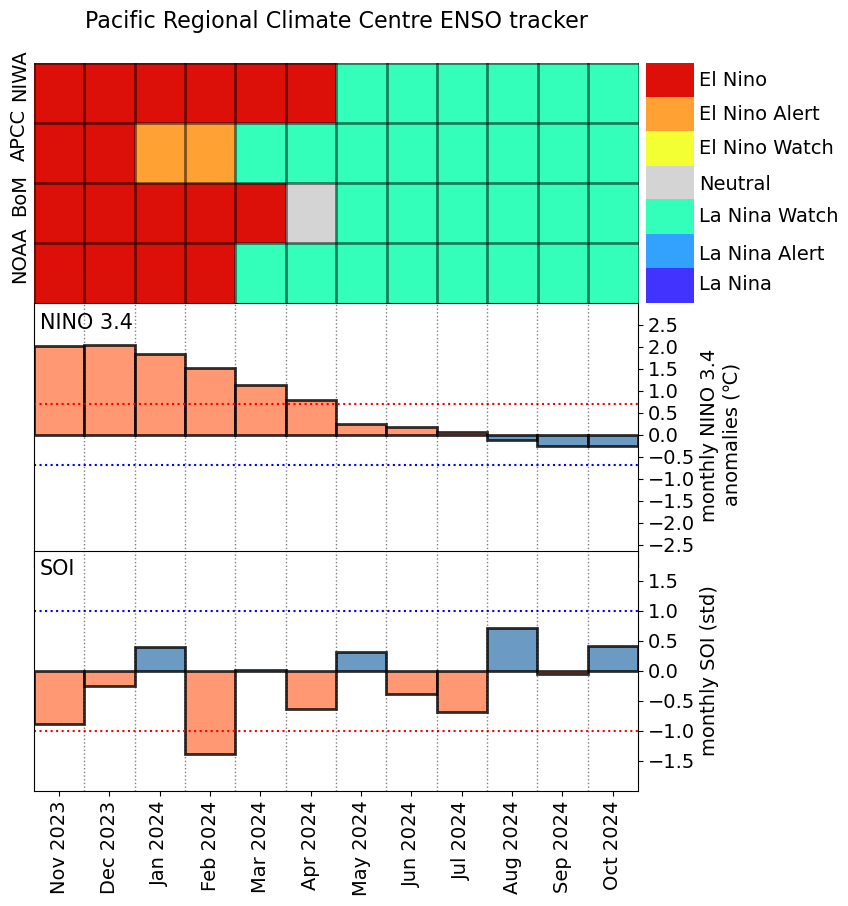

In [119]:
f = plt.figure(figsize=(8,8))

# defines the axes [left, bottom, width, height]

ax0 = f.add_axes([0.1, 0.66, 0.9, 0.3])

ax0.set_title("Pacific Regional Climate Centre ENSO tracker\n", fontsize=16)

ax1 = f.add_axes([0.1, 0.33, 0.755, 0.33])

ax2 = f.add_axes([0.1, 0.05, 0.755, 0.30])

#============================================================================================================================
# first set of axes: ENSO categories heatmap 

sns.heatmap(enso_cat_int.T, cmap=cm, center=0, vmin=-3, vmax=3, ax=ax0, \
            cbar_kws={'aspect':5, 'pad':0.01}) 

colorbar = ax0.collections[0].colorbar 

ax0.set_yticks([0.8, 1.8, 2.8, 3.8]);

ax0.set_yticklabels(['NOAA','BoM','APCC','NIWA'], fontsize=14)

ax0.set_ylim(bottom=0,top=4)

[ax0.axvline(x, color='k', lw=2, alpha=0.5) for x in range(0,len(enso_cat_int) + 1)];

[ax0.axhline(x, color='k', lw=2, alpha=0.5) for x in range(1,5)];

ax0.tick_params(direction='out', length=0, width=0)

colorbar.set_ticks([-2.5, -1.75, -0.8,  0.,  0.90, 1.75,  2.6])

colorbar.set_ticklabels(["La Nina", "La Nina Alert", "La Nina Watch", "Neutral", "El Nino Watch", "El Nino Alert", "El Nino"])    

colorbar.ax.tick_params(direction='out', length=0, width=0)

#============================================================================================================================
# second set of axes: ENSO barplot

ax1.bar(basis[nino_values>=0],nino_values[nino_values>=0], width=1, facecolor='coral', alpha=.8, edgecolor='k', lw=2)
ax1.bar(basis[nino_values<0],nino_values[nino_values<0], width=1, facecolor='steelblue', alpha=.8, edgecolor='k', lw=2)

ax1.set_xticks(basis)

ax1.set_xticklabels(dates_str, rotation=90)

ax1.set_xlim([-0.5,len(dates) - 0.5])

# get the minimum and maximum values, and set limits and ticks for the y-axis accordingly 
max_nino = np.ceil(np.max(np.abs(nino_values)))
min_nino =- max_nino

if max_nino > 1: 
    ax1.set_ylim([min_nino, max_nino])
    ax1.set_yticks(np.arange(min_nino+0.5, max_nino, 0.5))
else: 
    ax1.set_ylim([-1, 1])
    ax1.set_yticks([-0.7, 0, 0.7])                  
    
ax1.axhline(-0.7, ls=':', color='b')
ax1.axhline(0.7, ls=':', color='r')

ax1.yaxis.tick_right()

ax1.set_ylabel('monthly NINO 3.4\nanomalies (℃)', fontsize=14)

ax1.yaxis.set_label_position("right")

[ax1.axvline(x, color='k', lw=1, alpha=0.5, ls=':') for x in np.arange(0.5,len(dates)-0.5)];

ax1.set_xlabel('month', fontsize=14)

ax1.text(0.01, 0.9, 'NINO 3.4', transform=ax1.transAxes, fontsize=15)

#============================================================================================================================
# second set of axes: SOI barplot

ax2.bar(basis[soi_values>=0],soi_values[soi_values>=0], width=1, facecolor='steelblue', alpha=.8, edgecolor='k', lw=2)
ax2.bar(basis[soi_values<0],soi_values[soi_values<0], width=1, facecolor='coral', alpha=.8, edgecolor='k', lw=2)

ax2.set_xticks(basis)

ax2.set_xticklabels(dates_str, rotation=90)

ax2.set_xlim([-0.5,len(dates) - 0.5])

# get the minimum and maximum values, and set limits and ticks for the y-axis accordingly 
max_soi = np.ceil(np.max(np.abs(soi_values)))
min_soi =- max_soi

if max_soi > 1.5: 
    ax2.set_ylim([min_soi, max_soi])
    ax2.set_yticks(np.arange(min_soi+0.5, max_soi, 0.5))
else: 
    ax2.set_ylim([-1.5, 1.5])
    ax2.set_yticks([-1, 0, 1])       

ax2.axhline(-1, ls=':', color='r')
ax2.axhline(1, ls=':', color='b')

ax2.yaxis.tick_right()

ax2.yaxis.set_label_position("right")

ax2.set_ylabel('monthly SOI (std)', fontsize=14)

ax2.yaxis.set_label_position("right")

ax2.text(0.01, 0.9, 'SOI', transform=ax2.transAxes, fontsize=15)

[ax2.axvline(x, color='k', lw=1, alpha=0.5, ls=':') for x in np.arange(0.5,len(dates)-0.5)];

# f.patch.set_facecolor('0.99')
f.patch.set_facecolor('w')

### saves to file 

In [120]:
f.savefig('../figures/prototype_Pacific_RCC.png', dpi=200, bbox_inches='tight')

### push to github

In [121]:
%cd "/mnt/c/Users/fauchereaun/operational/PI-RCC/Pacific_RCC" 

/mnt/c/Users/fauchereaun/operational/PI-RCC/Pacific_RCC


In [ ]:
# Specify the Git commands as strings
git_add = 'git add figures/prototype_Pacific_RCC.png notebooks/Pacific_RCC_ENSO_tracker.ipynb'
git_commit = f'git commit -m "updated on {year}-{month}"'
git_push = 'git push'

In [126]:
!{git_add}

In [127]:
!{git_commit}

[main 2e2158a] updated on 2024-10
 9 files changed, 9014 insertions(+), 1928 deletions(-)
 create mode 100644 figures/.DS_Store
 create mode 100644 notebooks/.DS_Store
 create mode 100644 notebooks/.ipynb_checkpoints/Pacific_RCC_ENSO_tracker-checkpoint.ipynb
 copy notebooks/{Pacific_RCC_ENSO_tracker.ipynb => .ipynb_checkpoints/Pacific_RCC_ENSO_tracker_v3-checkpoint.ipynb} (93%)
 rewrite notebooks/Pacific_RCC_ENSO_tracker.ipynb (74%)
 create mode 100644 notebooks/archive/.ipynb_checkpoints/Pacific_RCC_ENSO_tracker_v2-checkpoint.ipynb
 create mode 100644 notebooks/archive/Pacific_RCC_ENSO_tracker.ipynb
 create mode 100644 notebooks/archive/Pacific_RCC_ENSO_tracker_v2.ipynb
 create mode 100644 notebooks/figures/prototype_Pacific_RCC.png


In [61]:
# %cd "/Users/ben.noll/weather/Pacific_RCC/notebooks/figures"

# # Commit and push changes to a Git repository from Jupyter Notebook

# # Specify the Git commands as strings
# git_add = 'git add -A'
# git_commit = 'git commit -m "monthly update"'
# git_push = 'git push'

# # Execute Git commands using the ! prefix
# !{git_add}
# !{git_commit}
# !{git_push}

/Users/ben.noll/weather/Pacific_RCC/notebooks/figures
On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean
Everything up-to-date
